# Product Market Link Prediction

_A hidden connection is stronger than an obvious one_ - Heraclitus

Link prediction in network analysis seeks to infer missing or future connections between nodes based on observed relationships. In the context of product markets, firms are interconnected through shared product similarities and competitive interactions. We construct firm networks from text-based product market similarity data, and explore the application of several link prediction algorithms. Additionally, accuracy metrics such as precision-recall and ROC curves are examined to assess the performance of these predictions.


In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import zipfile
import io
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn import metrics
import matplotlib.pyplot as plt
import networkx as nx
from finds.database import SQL, RedisDB
from finds.structured import CRSP, BusDay, PSTAT
from finds.readers import requests_get
from finds.recipes import graph_info
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
bd = BusDay(sql, verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
pstat = PSTAT(sql, bd, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)

## Product market linkages

Hoberg and Phillips (2016) developed a text-based measure of firm similarity by analyzing product descriptions in 10-K filings. Their methodology constructs firm-by-firm similarity scores using word vectors, filtering out common words and focusing on nouns and proper nouns while excluding geographic terms. This approach captures shifts in product markets over time, as revealed by their business descriptions in annual company filings.

The **TNIC-3** dataset is calibrated to align with the granularity of three-digit SIC codes, providing a structured industry classification. The **TNIC-2** dataset represents a more comprehensive version, including all firm pairs, even those with weak relationships. 

Source: [Hoberg and Phillips Industry Classification](https://hobergphillips.tuck.dartmouth.edu/industryclass.htm)

The TNIC-2 and TNIC-3 datasets are retrieved from the Hoberg and Phillips website.

In [3]:
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'
tnic_data = {}
for scheme in ['tnic2', 'tnic3']:
    source = root + scheme + '_data.zip'
    if source.startswith('http'):
        response = requests_get(source)
        source = io.BytesIO(response.content)
    with zipfile.ZipFile(source).open(scheme + "_data.txt") as f:
        tnic_data[scheme] = pd.read_csv(f, sep='\s+')
for k,v in tnic_data.items():
    print(k, v.shape)

tnic2 (52812348, 4)
tnic3 (27161830, 4)


In [4]:
# extract last year of both tnic schemes, merge in permno, and require in univ
year = max(tnic_data['tnic2']['year'])
capsize = 10  # large cap (large than NYSE median)
univ = crsp.get_universe(bd.endyr(year))
univ = univ[univ['decile'] <= capsize]   
lookup = pstat.build_lookup('gvkey', 'lpermno', fillna=0)
nodes = {}
tnic = {}
edges = {}
for scheme in ['tnic2', 'tnic3']:
    tnic[scheme] = tnic_data[scheme][tnic_data[scheme].year == year].dropna()
    gvkeys = sorted(set(tnic[scheme]['gvkey1']).union(tnic[scheme]['gvkey2']))
    df = DataFrame(index=gvkeys, data=lookup(gvkeys), columns=['permno'])
    nodes[scheme] = df[df['permno'].gt(0)
                       & df['permno'].isin(univ.index)].drop_duplicates()
nodes['tnic2'] = nodes['tnic2'][nodes['tnic2'].index.isin(nodes['tnic3'].index)]
nodes['tnic3'] = nodes['tnic3'][nodes['tnic3'].index.isin(nodes['tnic2'].index)]

Using the TNIC-2 and TNIC-3 datasets, undirected graphs are constructed where nodes represent firms and edges indicate product market similarities based on the chosen granularity of the classification schemes.

In [5]:
# create graphs of tnic2 (denser graph) and tnic3 (sparser graph) schemes
for scheme in ['tnic2', 'tnic3']:
    e = tnic[scheme][tnic[scheme]['gvkey1'].isin(nodes[scheme].index) &
                     tnic[scheme]['gvkey2'].isin(nodes[scheme].index)]
    edges[scheme] = list(e[['gvkey1', 'gvkey2', 'score']]\
                         .itertuples(index=False, name=None))

tnic2 nodes = 3296 edges = 819984
tnic3 nodes = 3296 edges = 528012


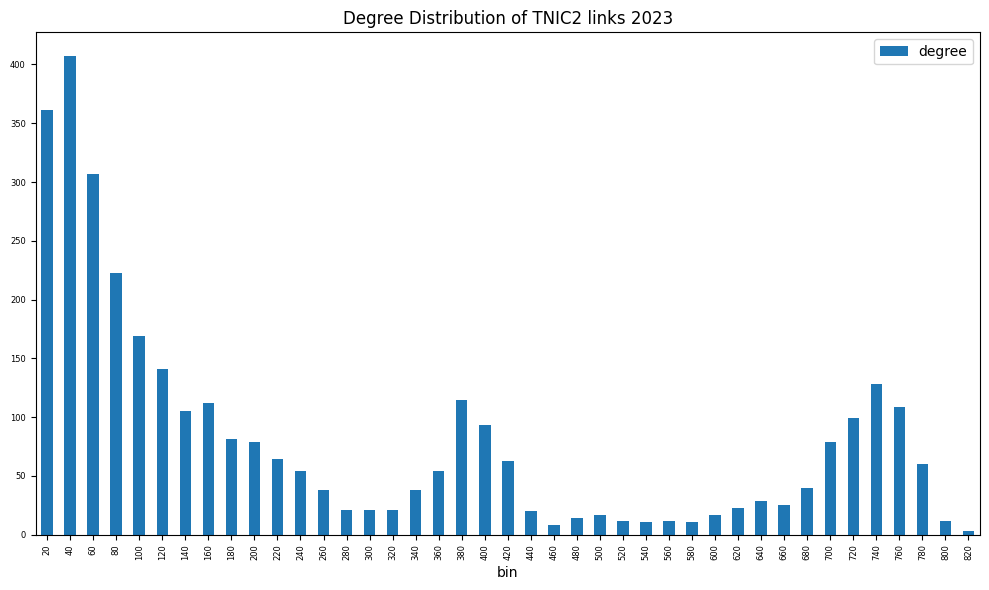

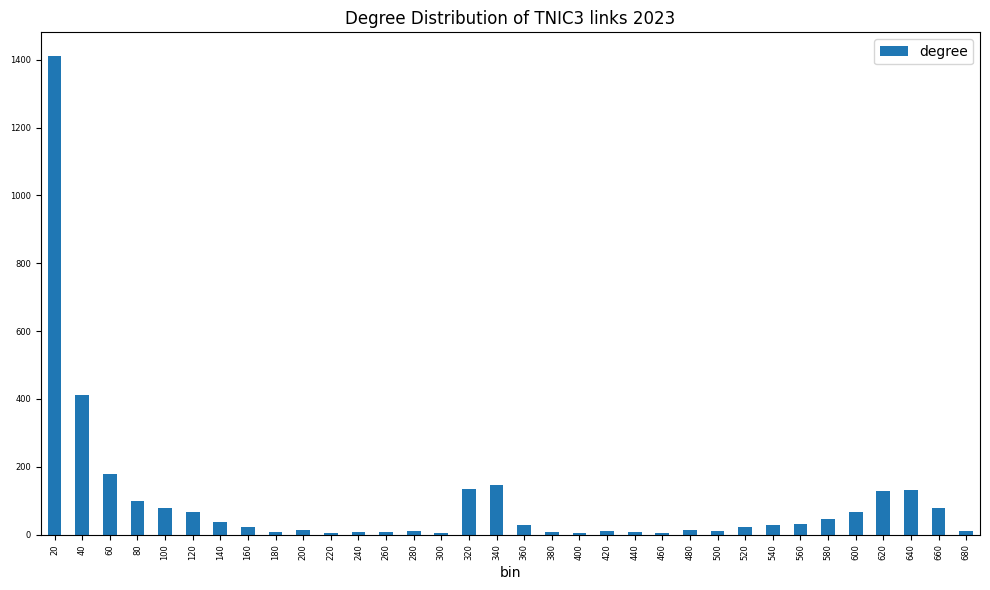

In [6]:
results = {}
G = {}
for (scheme, node), (_, edge) in zip(nodes.items(), edges.items()):
    print(scheme, 'nodes =', len(node), 'edges =', len(edge))

    # populate graph
    g = nx.Graph()
    g.add_nodes_from(node.index)
    g.add_weighted_edges_from(edge)

    # remove self-loops: not necessary
    g.remove_edges_from(nx.selfloop_edges(g))

    # graph info
    results[scheme] = Series(graph_info(g, fast=True))

    # Plot degree distribution
    fig, ax = plt.subplots(clear=True, figsize=(10, 6))
    degree = nx.degree_histogram(g)
    degree = DataFrame(data={'degree': degree[1:]},   # exclude degree 0
                       index=np.arange(1, len(degree)))
    degree['bin'] = (degree.index // (2*capsize) + 1) * (2*capsize)
    degree.groupby('bin').sum().plot(kind='bar', ax=ax, fontsize=6)
    ax.set_title(f'Degree Distribution of {scheme.upper()} links {year}')
    plt.tight_layout()

    G[scheme] = g

In [7]:
print(f"Graph properties of TNIC schemes {year}") 
DataFrame(results)

Graph properties of TNIC schemes 2023


,tnic2,tnic3
transitivity,0.834713,0.881587
average_clustering,0.592383,0.571318
connected,True,False
connected_components,1,25
size_largest_component,3296,3255
directed,False,False
weighted,True,True
negatively_weighted,False,False
edges,409992,264006
nodes,3296,3296


## Link prediction algorithms

Link prediction aims to identify missing or future connections between nodes in a network. Given a partially observed network, these algorithms infer which links are most likely to be added or missing based on existing connections and network structure.

Common link prediction algorithms include:

- **Jaccard Coefficient**: Measures the similarity between two nodes by comparing their shared neighbors relative to their total number of neighbors.
- **Resource Allocation**: Assigns a higher likelihood of connection between nodes that share many common neighbors, emphasizing smaller-degree nodes.
- **Adamic-Adar**: Enhances the Resource Allocation approach by weighting common neighbors based on their overall connectivity.
- **Preferential Attachment**: Predicts new links based on the idea that nodes with higher degrees are more likely to form new connections.


In [8]:
# helper to call link prediction algorithms
def link_prediction(G):
    """Predict link scores for all nonexistent edges in graph"""
    
    def links(links):
        """returns list of edge-score 3-tuples sorted by highest score"""
        return sorted(links, key=lambda x: x[2], reverse=True)
    
    resource = links(nx.resource_allocation_index(G))
    jaccard = links(nx.jaccard_coefficient(G))
    adamic = links(nx.adamic_adar_index(G))
    preferential = links(nx.preferential_attachment(G))
    return {'resource_allocation': resource,
            'jaccard_coefficient': jaccard,
            'adamic_adar': adamic,
            'preferential_attachment': preferential}

In [9]:
links = link_prediction(G['tnic3'])

## Accuracy metrics


Common metrics to assess the accuracy of link prediction (or any binary classification) models:

- **Precision**: The fraction of predicted links that are actual links.
- **Recall**: The fraction of actual links that were correctly predicted.
- **Accuracy**: The overall correctness of predictions.
- **Confusion Matrix**: A summary of prediction outcomes.
- **F1 Score**: A balanced measure between precision and recall, useful for imbalanced datasets. It is calculated as:

$$2 \dfrac{precision \cdot recall}{precision + recall} = \dfrac{TP}{TP + (FP+FN)/2}$$

where 
- False Positive (FP): Incorrectly predicted links.
- False Negative (FN): Missed actual links.
- True Positive (TP): Correctly predicted links.
- True Negative (TN): Correctly identified non-links.

### ROC Curve

The **Receiver Operating Characteristic (ROC) curve** and the **Area Under the Curve (AUC)** evaluates model performance by measuring the trade-off between true positive and false positive rates at various classification score thresholds. 

The ROC curve plots the following metrics on the two axes:
- **True Positive Rate (TPR)** (or **Sensitivity**) $= \frac{TP}{TP+FN}​$:  Measures how many actual positives are correctly identified.
- **False Positive Rate (FPR)** $= \frac{FP}{FP+TN}$: Measures how many negative cases are incorrectly classified as positive.

The AUC measures the area under the ROC curve and provides a single number to quantify model performance. A  higher AUC means the model is better at distinguishing between positive and negative classes. 





In [12]:
def make_sample(prediction, edges):
    """helper to extract predicted scores and gold labels"""
    names = [e[:2] for e in prediction]         # node-pairs of nonexistent edges
    scores = [e[-1] for e in prediction]        # predicted scores (ordered)
    gold = [e[:2] in edges for e in prediction] # gold labels of nonexistent edges
    return gold, scores, names  # actual, predicted score, names

Classification Report: resource_allocation
              precision    recall  f1-score   support

       False       0.99      0.99      0.99   5020168
        True       0.62      0.62      0.62    145986

    accuracy                           0.98   5166154
   macro avg       0.80      0.80      0.80   5166154
weighted avg       0.98      0.98      0.98   5166154

Classification Report: jaccard_coefficient
              precision    recall  f1-score   support

       False       0.99      0.99      0.99   5020168
        True       0.60      0.60      0.60    145986

    accuracy                           0.98   5166154
   macro avg       0.79      0.79      0.79   5166154
weighted avg       0.98      0.98      0.98   5166154

Classification Report: adamic_adar
              precision    recall  f1-score   support

       False       0.99      0.99      0.99   5020168
        True       0.60      0.60      0.60    145986

    accuracy                           0.98   5166154
   macr

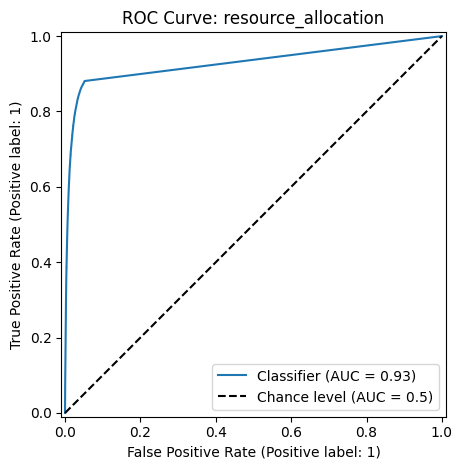

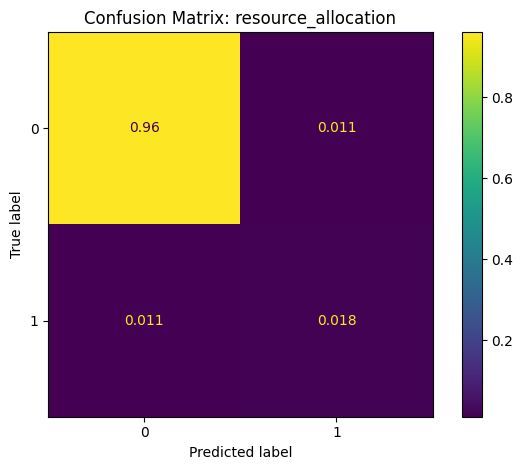

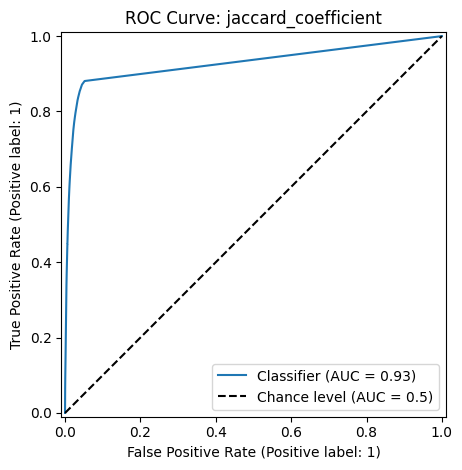

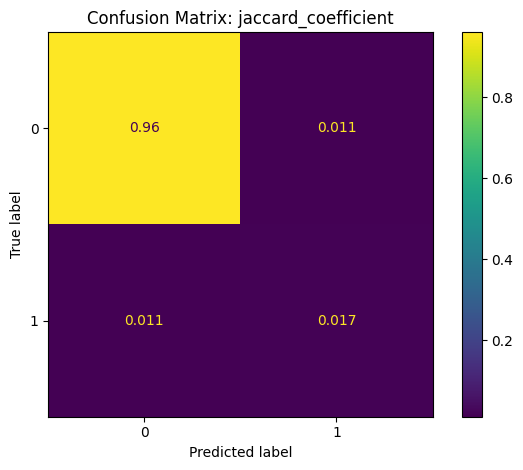

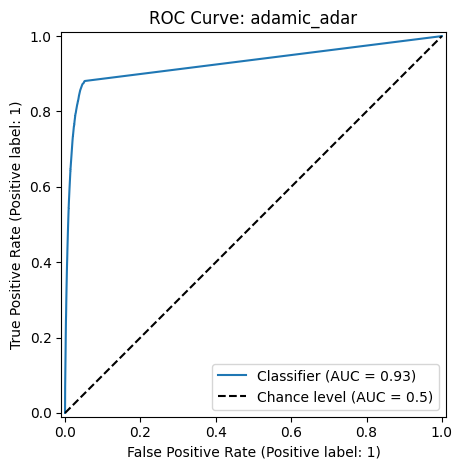

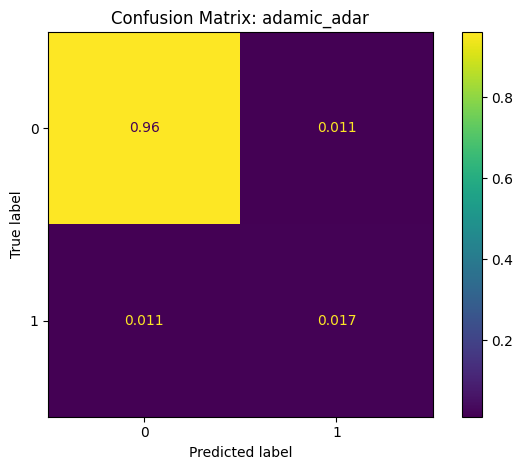

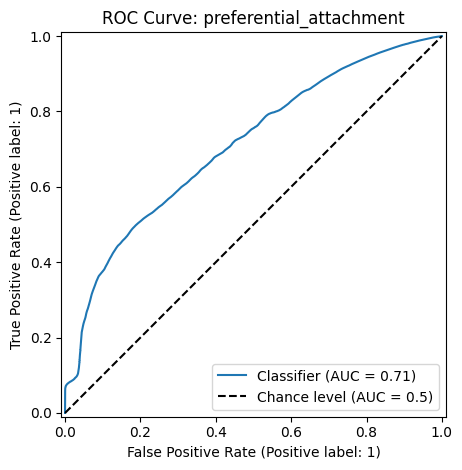

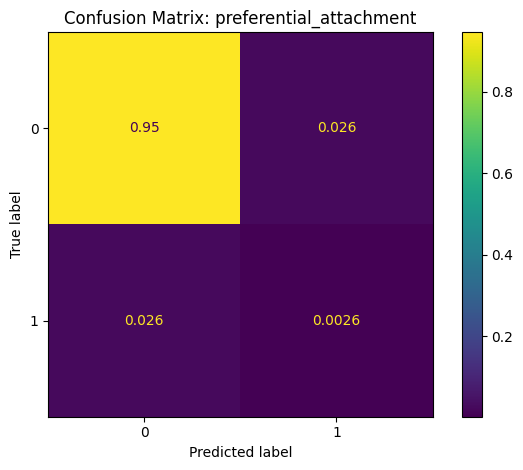

In [14]:
report = {}
for ifig, (method, pred) in enumerate(links.items()):

    # extract predicted scores and gold labels of nonexistent edges
#    y, scores, names = make_sample(pred, G['tnic2'].edges)

    names = [e[:2] for e in pred]                  # node-pairs of nonexistent edges
    scores = [e[-1] for e in pred]                 # predicted scores of edge
    y = [e[:2] in G['tnic2'].edges for e in pred]  # gold labels of nonexistent edges

    # plot roc curve
    metrics.RocCurveDisplay.from_predictions(y_true=y, y_pred=scores,
                                             plot_chance_level=True)
    plt.title(f"ROC Curve: {method}")
    plt.tight_layout()
    
    # set classification threshold at class proportion
    thresh = scores[sum(y)] 
    y_pred = [score >= thresh for score in scores]

    # generate and plot confusion matrix
    cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred, normalize='all')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix: {method}")
    plt.tight_layout()
    
    # generate classification report
    report[method] = metrics.classification_report(y_true=y, y_pred=y_pred)
    print(f"Classification Report: {method}")
    print(report[method])

__References:__

Gerard Hoberg and Gordon Phillips, 2016, Text-Based Network Industries and Endogenous Product Differentiation.Journal of Political Economy 124 (5), 1423-1465.

Gerard Hoberg and Gordon Phillips, 2010, Product Market Synergies and Competition in Mergers and Acquisitions: A Text-Based Analysis. Review of Financial Studies 23 (10), 3773-3811. 